[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dakimura/jquants-sample/blob/main/predictor.ipynb)

# J-Quants APIを用いた価格予測モデル生成

本ノートブックでは、data_retrieve.ipynbで保存したデータを用いて、
モデルの生成とそれによる価格の予測までを行います。

モデルには、J-Quantsファンダメンタルズ分析チャレンジで第2位を受賞された[UKIさんのモデル](https://github.com/UKI000/JQuants-Forum/blob/452a4f4bc086ef0a8b087efc707c51abad5ed50e/jquants01_fund_uki_predictor.py)を
ほぼそのまま使用させていただいています。

In [1]:
# 必要なライブラリのインストールとインポート
!pip install scikit-learn
!pip install xgboost pandas numpy

from datetime import datetime
import pandas as pd
import numpy as np
from dateutil import tz
import pickle
import os
import io
from typing import List

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# pandas の表示制限を調整します
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)

In [55]:
# 必要なコンフィグの定義
# データを保存しているGoogleドライブ上のディレクトリ
STORAGE_DIR_PATH = "/content/drive/MyDrive/drive_ws/marketdata"
# デバッグ中
# STORAGE_DIR_PATH = "/tmp/marketdata"

# CSVデータが保存されているファイルパス
stock_fin_csvfile_path = STORAGE_DIR_PATH + "/stock_fin.csv.gz"
stock_price_csvfile_path = STORAGE_DIR_PATH + "/stock_price.csv.gz"
# stock_labelsは今このノートブック内で作っているので特に保存する意味はないけれど
stock_labels_csvfile_path = STORAGE_DIR_PATH + "/stock_labels.csv.gz"
# 生成したモデルを保存するパス
model_dir = STORAGE_DIR_PATH + "/model/"

# デバッグ用の銘柄
example_codes = [72030, 92010, 67580] # toyota, jal, sony (特に意味はない)

TRAIN_START = "2017-01-01"
TRAIN_END = "2019-12-31"
TEST_START = "2020-01-01"
TEST_END = "2020-11-15"

# 訓練結果を保存するファイルパス
model_path = STORAGE_DIR_PATH + "/model"

# データを使用する期間
start_dt: datetime = datetime(2017, 1, 1) #, tzinfo=tz.gettz("Asia/Tokyo"))
end_dt: datetime = datetime(2022, 7, 31) #, tzinfo=tz.gettz("Asia/Tokyo"))

target_date = datetime(2022, 7, 24)
output_start_dt = datetime(2017, 7, 24)


## データセットの読み込み

事前に生成しておいたcsvデータを読み込み、データ型を調整します。

In [56]:
# ノートブックの冪等性を高めるためこれらの変数はこのセル以外でいじらない
stock_price_load:pd.DataFrame = pd.read_csv(stock_price_csvfile_path)
stock_fin_load:pd.DataFrame = pd.read_csv(stock_fin_csvfile_path)

# 財務情報のいくつかがobject型になっているので数値型に変換
numeric_cols_fin = ['AverageNumberOfShares', 'BookValuePerShare', 'EarningsPerShare','Equity', 'EquityToAssetRatio',
                'ForecastDividendPerShare1stQuarter', 'ForecastDividendPerShare2ndQuarter', 'ForecastDividendPerShare3rdQuarter',
                'ForecastDividendPerShareAnnual', 'ForecastDividendPerShareFiscalYearEnd', 'ForecastEarningsPerShare', 'ForecastNetSales', 'ForecastOperatingProfit',
                'ForecastOrdinaryProfit', 'ForecastProfit', 'NetSales', 'NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock',
                'OperatingProfit', 'OrdinaryProfit', 'Profit', 'ResultDividendPerShare1stQuarter','ResultDividendPerShare2ndQuarter','ResultDividendPerShare3rdQuarter',
                'ResultDividendPerShareAnnual','ResultDividendPerShareFiscalYearEnd','TotalAssets']
stock_fin_load[numeric_cols_fin] = stock_fin_load[numeric_cols_fin].apply(pd.to_numeric, errors='coerce', axis=1)

# object型をdatetime64[ns]型に変換
stock_price_load["Date"] = pd.to_datetime(stock_price_load["Date"])
stock_fin_load["DisclosedDate"] = pd.to_datetime(stock_fin_load["DisclosedDate"]) #開示時刻
stock_fin_load["CurrentFiscalYearEndDate"] = pd.to_datetime(stock_fin_load["CurrentFiscalYearEndDate"])  # 当事業年度終了日
stock_fin_load["CurrentFiscalYearStartDate"] = pd.to_datetime(stock_fin_load["CurrentFiscalYearStartDate"])
stock_fin_load["CurrentPeriodEndDate"] = pd.to_datetime(stock_fin_load["CurrentPeriodEndDate"]) # 当会計期間終了日

stock_price_load

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4,5,14,15,16,30,33,34,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,Code,Date,Open,High,Low,Close,Volume,TurnoverValue,AdjustmentFactor,AdjustmentOpen,AdjustmentHigh,AdjustmentLow,AdjustmentClose,AdjustmentVolume
0,0,13010,2017-01-04,2734.0,2755.0,2730.0,2742.0,31400.0,86163600.0,1.0,2734.0,2755.0,2730.0,2742.0,31400.0
1,0,13010,2017-01-05,2743.0,2747.0,2735.0,2738.0,17900.0,49058200.0,1.0,2743.0,2747.0,2735.0,2738.0,17900.0
2,0,13010,2017-01-06,2734.0,2744.0,2720.0,2740.0,19900.0,54482100.0,1.0,2734.0,2744.0,2720.0,2740.0,19900.0
3,0,13010,2017-01-10,2745.0,2754.0,2735.0,2748.0,24200.0,66437100.0,1.0,2745.0,2754.0,2735.0,2748.0,24200.0
4,0,13010,2017-01-11,2748.0,2752.0,2737.0,2745.0,9300.0,25523400.0,1.0,2748.0,2752.0,2737.0,2745.0,9300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5455316,4193,99970,2022-07-25,829.0,831.0,816.0,826.0,151200.0,124560100.0,1.0,829.0,831.0,816.0,826.0,151200.0
5455317,4193,99970,2022-07-26,826.0,827.0,816.0,825.0,133600.0,109994600.0,1.0,826.0,827.0,816.0,825.0,133600.0
5455318,4194,99970,2022-07-27,819.0,822.0,811.0,811.0,136500.0,111242500.0,1.0,819.0,822.0,811.0,811.0,136500.0
5455319,4193,99970,2022-07-28,813.0,816.0,801.0,816.0,187300.0,151653200.0,1.0,813.0,816.0,801.0,816.0,187300.0


[株式分析チュートリアル](https://japanexchangegroup.github.io/J-Quants-Tutorial/#introduction)で用いられたデータの形式を[J-Quants API](https://jpx.gitbook.io/j-quants-api/api-reference)を用いて再現するため、データを加工します。

In [57]:
# stock_price: データの互換性のための各種列名変換など
stock_price: pd.DataFrame = pd.DataFrame()
stock_price["Local Code"] = stock_price_load["Code"]
#stock_price["Date"] = stock_price_load["Date"]
stock_price["base_date"] = stock_price_load["Date"]
stock_price['EndOfDayQuote Date'] = stock_price_load["Date"]
stock_price["EndOfDayQuote Open"] = stock_price_load["AdjustmentOpen"].replace({0.0: np.nan})
stock_price["EndOfDayQuote High"] = stock_price_load["AdjustmentHigh"].replace({0.0: np.nan})
stock_price["EndOfDayQuote Low"] = stock_price_load["AdjustmentLow"].replace({0.0: np.nan})
stock_price["EndOfDayQuote Close"] = stock_price_load["AdjustmentClose"].replace({0.0: np.nan})
stock_price["EndOfDayQuote ExchangeOfficialClose"] = stock_price_load["AdjustmentClose"].replace({0.0: np.nan})
stock_price["EndOfDayQuote Volume"] = stock_price_load["AdjustmentVolume"]
#stock_price = stock_price.set_index("base_date")
#stock_price = stock_price.sort_index()

# stock_price["EndOfDayQuote Open"][stock_price["EndOfDayQuote Close"] == 0] = \
#     stock_price["EndOfDayQuote ExchangeOfficialClose"]
# stock_price["EndOfDayQuote High"][stock_price["EndOfDayQuote Close"] == 0] = \
#     stock_price["EndOfDayQuote ExchangeOfficialClose"]
# stock_price["EndOfDayQuote Low"][stock_price["EndOfDayQuote Close"] == 0] = \
#     stock_price["EndOfDayQuote ExchangeOfficialClose"]
# stock_price["EndOfDayQuote Close"][stock_price["EndOfDayQuote Close"] == 0] = \
#     stock_price["EndOfDayQuote ExchangeOfficialClose"]

# 前日終値の列を終値列から作成
stock_price["EndOfDayQuote PreviousClose"] = stock_price.groupby(["Local Code"])["EndOfDayQuote Close"].shift(1)

In [100]:
# stock_financial: データの互換性のための各種列名変換など
stock_fin: pd.DataFrame = pd.DataFrame()
stock_fin["Local Code"] = stock_fin_load["LocalCode"]
stock_fin["Result_FinancialStatement FiscalPeriodEnd"] = stock_fin_load["CurrentFiscalYearEndDate"]
stock_fin["Result_FinancialStatement TotalAssets"] = stock_fin_load["TotalAssets"] # 総資産
stock_fin["Result_FinancialStatement NetAssets"] = stock_fin_load["Equity"] # 純資産
stock_fin["Result_FinancialStatement NetSales"] = stock_fin_load["NetSales"] # 純売上高
stock_fin["Result_FinancialStatement OperatingIncome"] = stock_fin_load["OperatingProfit"]
stock_fin["Result_FinancialStatement OrdinaryIncome"] = stock_fin_load["OrdinaryProfit"]  # 経常利益
stock_fin["Result_FinancialStatement NetIncome"] = stock_fin_load["Profit"]  # 当期純利益
stock_fin["Result_FinancialStatement ReportType"] = stock_fin_load["TypeOfCurrentPeriod"]
stock_fin["base_date"] = stock_fin_load["DisclosedDate"]

stock_fin["TypeOfDocument"] = stock_fin_load["TypeOfDocument"] # 書類種別
stock_fin["RetrospectiveRestatement"] = stock_fin_load["RetrospectiveRestatement"] #修正再表示フラグ
stock_fin["Forecast_FinancialStatement FiscalPeriodEnd"] = stock_fin_load["CurrentFiscalYearEndDate"]
stock_fin["Forecast_FinancialStatement ReportType"] = stock_fin_load["TypeOfCurrentPeriod"]
stock_fin["Forecast_FinancialStatement NetSales"] = stock_fin_load["ForecastNetSales"]
stock_fin["Forecast_FinancialStatement OperatingIncome"] = stock_fin_load["ForecastOperatingProfit"]
stock_fin["Forecast_FinancialStatement NetIncome"] = stock_fin_load["ForecastProfit"]
stock_fin["Forecast_FinancialStatement OrdinaryIncome"] = stock_fin_load["ForecastOrdinaryProfit"]
#stock_fin = stock_fin.set_index("base_date")
#stock_fin = stock_fin.sort_index()

stock_fin.head()

,Local Code,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement ReportType,base_date,TypeOfDocument,RetrospectiveRestatement,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement NetIncome,Forecast_FinancialStatement OrdinaryIncome
0,27530,2017-03-31,2.238600e+10,1.829500e+10,2.276100e+10,2.147000e+09,2.234000e+09,1.494000e+09,3Q,2017-01-04,3QFinancialStatements_Consolidated_JP,False,2017-03-31,3Q,3.180000e+10,3.255000e+09,2.190000e+09,3.300000e+09
1,45750,2017-06-30,NaN,NaN,NaN,NaN,NaN,NaN,2Q,2017-01-04,ForecastRevision,NaN,2017-06-30,2Q,1.100000e+08,-4.650000e+08,-4.670000e+08,-4.660000e+08
2,33530,2017-02-28,2.510000e+10,7.566000e+09,2.212800e+10,8.200000e+08,7.780000e+08,6.290000e+08,3Q,2017-01-04,3QFinancialStatements_Consolidated_JP,False,2017-02-28,3Q,3.020000e+10,1.350000e+09,9.300000e+08,1.300000e+09
3,74630,2017-03-31,4.167600e+10,3.134800e+10,1.461900e+10,4.018000e+09,4.576000e+09,3.002000e+09,3Q,2017-01-05,3QFinancialStatements_Consolidated_JP,False,2017-03-31,3Q,2.150000e+10,6.400000e+09,4.400000e+09,6.700000e+09
4,99770,2017-02-28,2.760700e+10,1.767800e+10,7.893000e+10,1.786000e+09,1.845000e+09,1.059000e+09,3Q,2017-01-05,3QFinancialStatements_NonConsolidated_JP,False,2017-02-28,3Q,1.055000e+11,2.650000e+09,1.500000e+09,2.700000e+09


## 訓練とモデルの保存

特徴量を生成していきます。

In [59]:
# stock_priceを使ったテクニカル指標
def get_technical(stock_price:pd.DataFrame, code:int)->pd.DataFrame:
    technical_df = stock_price[stock_price["Local Code"] == code].copy()
    # 終値
    technical_df["close"] = technical_df["EndOfDayQuote Close"]
    # 騰落率
    technical_df["ror_1"] = technical_df["EndOfDayQuote Close"].pct_change(1)
    technical_df["ror_5"] = technical_df["EndOfDayQuote Close"].pct_change(5)
    technical_df["ror_10"] = technical_df["EndOfDayQuote Close"].pct_change(10)
    technical_df["ror_20"] = technical_df["EndOfDayQuote Close"].pct_change(20)
    technical_df["ror_40"] = technical_df["EndOfDayQuote Close"].pct_change(40)
    technical_df["ror_60"] = technical_df["EndOfDayQuote Close"].pct_change(60)
    technical_df["ror_100"] = technical_df["EndOfDayQuote Close"].pct_change(100)

    # 売買代金
    technical_df["volume"] = technical_df["EndOfDayQuote Close"] * technical_df["EndOfDayQuote Volume"]
    technical_df = technical_df.replace([np.inf, -np.inf], np.nan)

    technical_df["vol_1"] = technical_df["volume"]
    technical_df["vol_5"] = technical_df["volume"].rolling(5).mean() # 5日移動平均
    technical_df["vol_10"] = technical_df["volume"].rolling(10).mean()
    technical_df["vol_20"] = technical_df["volume"].rolling(20).mean()
    technical_df["vol_40"] = technical_df["volume"].rolling(40).mean()
    technical_df["vol_60"] = technical_df["volume"].rolling(60).mean()
    technical_df["vol_100"] = technical_df["volume"].rolling(100).mean()
    technical_df["d_vol"] = technical_df["volume"] / technical_df["vol_20"]

    # レンジ (前日の終値に対して何%値動きしたか)
    technical_df["range"] = (
        technical_df[["EndOfDayQuote PreviousClose", "EndOfDayQuote High"]].max(axis=1) 
        - technical_df[["EndOfDayQuote PreviousClose", "EndOfDayQuote Low"]].min(axis=1)
        ) / technical_df["EndOfDayQuote PreviousClose"]
    technical_df = technical_df.replace([np.inf, -np.inf], np.nan)

    # レンジの移動平均
    technical_df["atr_1"] = technical_df["range"]
    technical_df["atr_5"] = technical_df["range"].rolling(5).mean()
    technical_df["atr_10"] = technical_df["range"].rolling(10).mean()
    technical_df["atr_20"] = technical_df["range"].rolling(20).mean()
    technical_df["atr_40"] = technical_df["range"].rolling(40).mean()
    technical_df["atr_60"] = technical_df["range"].rolling(60).mean()
    technical_df["atr_100"] = technical_df["range"].rolling(100).mean()
    technical_df["d_atr"] = technical_df["range"] / technical_df["atr_20"]

    # ギャップレンジ
    technical_df["gap_range"] = (np.abs(technical_df["EndOfDayQuote Open"] - technical_df["EndOfDayQuote PreviousClose"])) / technical_df[
        "EndOfDayQuote PreviousClose"]
    technical_df["g_atr_1"] = technical_df["gap_range"]
    technical_df["g_atr_5"] = technical_df["gap_range"].rolling(5).mean()
    technical_df["g_atr_10"] = technical_df["gap_range"].rolling(10).mean()
    technical_df["g_atr_20"] = technical_df["gap_range"].rolling(20).mean()
    technical_df["g_atr_40"] = technical_df["gap_range"].rolling(40).mean()
    technical_df["g_atr_60"] = technical_df["gap_range"].rolling(60).mean()
    technical_df["g_atr_100"] = technical_df["gap_range"].rolling(100).mean()

    # デイレンジ
    technical_df["day_range"] = (technical_df["EndOfDayQuote High"] - technical_df["EndOfDayQuote Low"]) / technical_df[
        "EndOfDayQuote PreviousClose"]
    technical_df["d_atr_1"] = technical_df["day_range"]
    technical_df["d_atr_5"] = technical_df["day_range"].rolling(5).mean()
    technical_df["d_atr_10"] = technical_df["day_range"].rolling(10).mean()
    technical_df["d_atr_20"] = technical_df["day_range"].rolling(20).mean()
    technical_df["d_atr_40"] = technical_df["day_range"].rolling(40).mean()
    technical_df["d_atr_60"] = technical_df["day_range"].rolling(60).mean()
    technical_df["d_atr_100"] = technical_df["day_range"].rolling(100).mean()

    # ヒゲレンジ
    technical_df["hig_range"] = ((technical_df["EndOfDayQuote High"] - technical_df["EndOfDayQuote Low"]) - np.abs(
        technical_df["EndOfDayQuote Open"] - technical_df["EndOfDayQuote Close"])) / technical_df["EndOfDayQuote PreviousClose"]
    technical_df["h_atr_1"] = technical_df["hig_range"]
    technical_df["h_atr_5"] = technical_df["hig_range"].rolling(5).mean()
    technical_df["h_atr_10"] = technical_df["hig_range"].rolling(10).mean()
    technical_df["h_atr_20"] = technical_df["hig_range"].rolling(20).mean()
    technical_df["h_atr_40"] = technical_df["hig_range"].rolling(40).mean()
    technical_df["h_atr_60"] = technical_df["hig_range"].rolling(60).mean()
    technical_df["h_atr_100"] = technical_df["hig_range"].rolling(100).mean()

    # ボラティリティ
    technical_df["vola_5"] = technical_df["ror_1"].rolling(5).std()
    technical_df["vola_10"] = technical_df["ror_1"].rolling(10).std()
    technical_df["vola_20"] = technical_df["ror_1"].rolling(20).std()
    technical_df["vola_40"] = technical_df["ror_1"].rolling(40).std()
    technical_df["vola_60"] = technical_df["ror_1"].rolling(60).std()
    technical_df["vola_100"] = technical_df["ror_1"].rolling(100).std()

    # HLバンド
    technical_df["hl_5"] = technical_df["EndOfDayQuote High"].rolling(5).max() - technical_df["EndOfDayQuote Low"].rolling(5).min()
    technical_df["hl_10"] = technical_df["EndOfDayQuote High"].rolling(10).max() - technical_df["EndOfDayQuote Low"].rolling(10).min()
    technical_df["hl_20"] = technical_df["EndOfDayQuote High"].rolling(20).max() - technical_df["EndOfDayQuote Low"].rolling(20).min()
    technical_df["hl_40"] = technical_df["EndOfDayQuote High"].rolling(40).max() - technical_df["EndOfDayQuote Low"].rolling(40).min()
    technical_df["hl_60"] = technical_df["EndOfDayQuote High"].rolling(60).max() - technical_df["EndOfDayQuote Low"].rolling(60).min()
    technical_df["hl_100"] = technical_df["EndOfDayQuote High"].rolling(100).max() - technical_df["EndOfDayQuote Low"].rolling(100).min()

    # マーケットインパクト
    technical_df["mi"] = technical_df["range"] / (technical_df["EndOfDayQuote Volume"] * technical_df["EndOfDayQuote Close"])
    technical_df = technical_df.replace([np.inf, -np.inf], np.nan)

    technical_df["mi_5"] = technical_df["mi"].rolling(5).mean()
    technical_df["mi_10"] = technical_df["mi"].rolling(10).mean()
    technical_df["mi_20"] = technical_df["mi"].rolling(20).mean()
    technical_df["mi_40"] = technical_df["mi"].rolling(40).mean()
    technical_df["mi_60"] = technical_df["mi"].rolling(60).mean()
    technical_df["mi_100"] = technical_df["mi"].rolling(100).mean()

    feat = ["EndOfDayQuote Date", "Local Code", "close",
            "ror_1", "ror_5", "ror_10", "ror_20", "ror_40", "ror_60", "ror_100",
            "vol_1", "vol_5", "vol_10", "vol_20", "vol_40", "vol_60", "vol_100", "d_vol",
            "atr_1", "atr_5", "atr_10", "atr_20", "atr_40", "atr_60", "atr_100", "d_atr",
            "g_atr_1", "g_atr_5", "g_atr_10", "g_atr_20", "g_atr_40", "g_atr_60", "g_atr_100",
            "d_atr_1", "d_atr_5", "d_atr_10", "d_atr_20", "d_atr_40", "d_atr_60", "d_atr_100",
            "h_atr_1", "h_atr_5", "h_atr_10", "h_atr_20", "h_atr_40", "h_atr_60", "h_atr_100",
            "vola_5", "vola_10", "vola_20", "vola_40", "vola_60", "vola_100",
            "hl_5", "hl_10", "hl_20", "hl_40", "hl_60", "hl_100",
            "mi_5", "mi_10", "mi_20", "mi_40", "mi_60", "mi_100"]
    technical_df = technical_df[feat]
    technical_df.columns = ["datetime", "code", "close",
                      "ror_1", "ror_5", "ror_10", "ror_20", "ror_40", "ror_60", "ror_100",
                      "vol_1", "vol_5", "vol_10", "vol_20", "vol_40", "vol_60", "vol_100", "d_vol",
                      "atr_1", "atr_5", "atr_10", "atr_20", "atr_40", "atr_60", "atr_100", "d_atr",
                      "g_atr_1", "g_atr_5", "g_atr_10", "g_atr_20", "g_atr_40", "g_atr_60", "g_atr_100",
                      "d_atr_1", "d_atr_5", "d_atr_10", "d_atr_20", "d_atr_40", "d_atr_60", "d_atr_100",
                      "h_atr_1", "h_atr_5", "h_atr_10", "h_atr_20", "h_atr_40", "h_atr_60", "h_atr_100",
                      "vola_5", "vola_10", "vola_20", "vola_40", "vola_60", "vola_100",
                      "hl_5", "hl_10", "hl_20", "hl_40", "hl_60", "hl_100",
                      "mi_5", "mi_10", "mi_20", "mi_40", "mi_60", "mi_100"]
    technical_df["datetime"] = pd.to_datetime(technical_df["datetime"])
    technical_df = technical_df.set_index(["datetime", "code"])
    return technical_df

# example
get_technical(stock_price, example_codes[0])

,,close,ror_1,ror_5,ror_10,ror_20,ror_40,ror_60,ror_100,vol_1,vol_5,vol_10,vol_20,vol_40,vol_60,vol_100,d_vol,atr_1,atr_5,atr_10,atr_20,atr_40,atr_60,atr_100,d_atr,g_atr_1,g_atr_5,g_atr_10,g_atr_20,g_atr_40,g_atr_60,g_atr_100,d_atr_1,d_atr_5,d_atr_10,d_atr_20,d_atr_40,d_atr_60,d_atr_100,h_atr_1,h_atr_5,h_atr_10,h_atr_20,h_atr_40,h_atr_60,h_atr_100,vola_5,vola_10,vola_20,vola_40,vola_60,vola_100,hl_5,hl_10,hl_20,hl_40,hl_60,hl_100,mi_5,mi_10,mi_20,mi_40,mi_60,mi_100
datetime,code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-04,72030,1419.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.775932e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,72030,1409.8,-0.006763,NaN,NaN,NaN,NaN,NaN,NaN,5.388256e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000986,NaN,NaN,NaN,NaN,NaN,NaN,0.009582,NaN,NaN,NaN,NaN,NaN,NaN,0.003804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,72030,1386.0,-0.016882,NaN,NaN,NaN,NaN,NaN,NaN,8.029167e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029650,NaN,NaN,NaN,NaN,NaN,NaN,0.016740,NaN,NaN,NaN,NaN,NaN,NaN,0.003972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-10,72030,1372.2,-0.009957,NaN,NaN,NaN,NaN,NaN,NaN,6.127628e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001154,NaN,NaN,NaN,NaN,NaN,NaN,0.013997,NaN,NaN,NaN,NaN,NaN,NaN,0.005195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-11,72030,1382.4,0.007433,NaN,NaN,NaN,NaN,NaN,NaN,4.565583e+10,6.177313e+10,NaN,NaN,NaN,NaN,NaN,NaN,0.009182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005539,NaN,NaN,NaN,NaN,NaN,NaN,0.007142,NaN,NaN,NaN,NaN,NaN,NaN,0.005247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,72030,2166.0,-0.016572,0.001387,0.026054,0.025811,0.039347,-0.010959,0.029468,3.581351e+10,4.832440e+10,4.896478e+10,5.375573e+10,5.439469e+10,5.626454e+10,6.017344e+10,0.666227,0.017934,0.011741,0.015307,0.018200,0.020946,0.022954,0.025506,0.985393,0.011578,0.005896,0.006293,0.007058,0.010212,0.010315,0.011715,0.016118,0.011102,0.013567,0.015873,0.016737,0.019236,0.020513,0.011124,0.008403,0.006552,0.006986,0.008366,0.009406,0.009988,0.009923,0.011636,0.015020,0.017115,0.017316,0.020480,43.0,107.5,162.5,225.0,311.5,477.5,2.558944e-13,3.243534e-13,3.464288e-13,3.900106e-13,4.051036e-13,4.214310e-13
2022-07-26,72030,2166.0,0.000000,-0.005053,0.006506,0.020976,0.018575,-0.006422,0.012859,2.679147e+10,4.430465e+10,4.560499e+10,5.322675e+10,5.290680e+10,5.587191e+10,5.986892e+10,0.503346,0.010388,0.012339,0.014095,0.017891,0.020593,0.022857,0.025363,0.580629,0.005309,0.006311,0.005450,0.006719,0.010128,0.010373,0.011754,0.010388,0.011700,0.013445,0.015564,0.016505,0.019139,0.020370,0.005078,0.008587,0.006468,0.006778,0.008295,0.009266,0.009942,0.009324,0.010034,0.015001,0.016827,0.017306,0.020417,46.0,107.5,162.5,225.0,311.5,477.5,3.018892e-13,3.258661e-13,3.436378e-13,3.926152e-13,4.061999e-13,4.209907e-13
2022-07-27,72030,2169.0,0.001385,-0.011395,0.024805,0.000692,0.021908,0.001616,0.016878,3.423506e+10,3.918059e+10,4.392159e+10,5.211586e+10,5.230319e+10,5.520457e+10,5.971691e+10,0.656903,0.014774,0.012767,0.013598,0.017545,0.020657,0.022828,0.025347,0.842043,0.005540,0.005306,0.006004,0.006596,0.010061,0.010206,0.011720,0.014774,0.012404,0.012948,0.015501,0.016569,0.019152,0.020354,0.007849,0.008457,0.006928,0.007053,0.008344,0.009313,0

In [96]:
# stock_finを使った指標
def get_financial(stock_fin:pd.DataFrame, code:int)->pd.DataFrame:
    fin_df = stock_fin[stock_fin["Local Code"] == code].copy()

    # TypeOfDocumentの値によってはTotalAssetsなどの値がNaNになっているのでffill
    fin_df = fin_df.ffill()

    # --- 本決算／中間決算フラグ、修正開示フラグ、事後修正有無フラグ ---
    fin_df["annual"] = 0 # 0: 中間決算, 1:本決算
    fin_df["revision"] = 0 # 1: 修正再表示
    # FYFinancialStatements*** は本決算
    fin_df.loc[fin_df["TypeOfDocument"].isin(["FYFinancialStatements_Consolidated_JP", "FYFinancialStatements_Consolidated_US", "FYFinancialStatements_Consolidated_IFRS"]), "annual"] = 1
    #fin_df.loc[fin_df["RetrospectiveRestatement"]]
    fin_df.loc[fin_df["RetrospectiveRestatement"]==True, "revision"] = 1
    feat1 = ["annual", "revision"]

    # --- 原系列 ---

    # --- r_sales ---
    fin_df["pre_result_period_end"] = fin_df["Result_FinancialStatement FiscalPeriodEnd"].shift(1)
    fin_df["r_sales"] = np.nan

    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_sales"] = fin_df[
        "Result_FinancialStatement NetSales"].diff(1)
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_sales"] = fin_df[
        "Result_FinancialStatement NetSales"]
    fin_df["r_sales"] = fin_df["r_sales"].ffill()

    # --- r_ope_income ---
    fin_df["r_ope_income"] = np.nan
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_ope_income"] = fin_df[
        "Result_FinancialStatement OperatingIncome"].diff(1)
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_ope_income"] = fin_df[
        "Result_FinancialStatement OperatingIncome"]
    fin_df["r_ope_income"] = fin_df["r_ope_income"].ffill()

    # --- r_ord_income ---
    fin_df["r_ord_income"] = np.nan
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_ord_income"] = fin_df[
        "Result_FinancialStatement OrdinaryIncome"].diff(1)
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_ord_income"] = fin_df[
        "Result_FinancialStatement OrdinaryIncome"]
    fin_df["r_ord_income"] = fin_df["r_ord_income"].ffill()

    # --- r_net_income ---
    fin_df["r_net_income"] = np.nan
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] != "1Q")), "r_net_income"] = fin_df[
        "Result_FinancialStatement NetIncome"].diff(1)
    fin_df.loc[((fin_df["Result_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_result_period_end"]) & (
            fin_df["Result_FinancialStatement ReportType"] == "1Q")), "r_net_income"] = fin_df[
        "Result_FinancialStatement NetIncome"]
    fin_df["r_net_income"] = fin_df["r_net_income"].ffill()

    # --- pre_forcast_period_end ---
    fin_df["pre_forecast_period_end"] = fin_df["Forecast_FinancialStatement FiscalPeriodEnd"].shift(1)

    # --- f_sales ---
    fin_df["f_sales"] = np.nan
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_sales"] = fin_df[
        "Forecast_FinancialStatement NetSales"].diff(1)
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_sales"] = fin_df[
        "Forecast_FinancialStatement NetSales"]
    fin_df["f_sales"] = fin_df["f_sales"].ffill()

    # --- f_ope_income ---
    fin_df["f_ope_income"] = np.nan
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_ope_income"] = fin_df[
        "Forecast_FinancialStatement OperatingIncome"].diff(1)
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_ope_income"] = fin_df[
        "Forecast_FinancialStatement OperatingIncome"]
    fin_df["f_ope_income"] = fin_df["f_ope_income"].ffill()

    # --- f_ord_income ---
    fin_df["f_ord_income"] = np.nan
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_ord_income"] = fin_df[
        "Forecast_FinancialStatement OrdinaryIncome"].diff(1)
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_ord_income"] = fin_df[
        "Forecast_FinancialStatement OrdinaryIncome"]
    fin_df["f_ord_income"] = fin_df["f_ord_income"].ffill()

    # --- f_net_income ---
    fin_df["f_net_income"] = np.nan
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] != "1Q")), "f_net_income"] = fin_df[
        "Forecast_FinancialStatement NetIncome"].diff(1)
    fin_df.loc[((fin_df["Forecast_FinancialStatement FiscalPeriodEnd"] != fin_df["pre_forecast_period_end"]) & (
            fin_df["Forecast_FinancialStatement ReportType"] == "1Q")), "f_net_income"] = fin_df[
        "Forecast_FinancialStatement NetIncome"]
    fin_df["f_net_income"] = fin_df["f_net_income"].ffill()

    # --------------------
    fin_df["r_expense1"] = fin_df["r_sales"] - fin_df["r_ope_income"]
    fin_df["r_expense2"] = fin_df["r_ope_income"] - fin_df["r_ord_income"]
    fin_df["r_expense3"] = fin_df["r_ord_income"] - fin_df["r_net_income"]

    fin_df["f_expense1"] = fin_df["f_sales"] - fin_df["f_ope_income"]
    fin_df["f_expense2"] = fin_df["f_ope_income"] - fin_df["f_ord_income"]
    fin_df["f_expense3"] = fin_df["f_ord_income"] - fin_df["f_net_income"]

    fin_df["r_assets"] = fin_df["Result_FinancialStatement TotalAssets"]
    fin_df["r_equity"] = fin_df["Result_FinancialStatement NetAssets"]

    # 現在 J-Quants APIからは取れなさそう
    # fin_df["operating_cf"] = fin_df["Result_FinancialStatement CashFlowsFromOperatingActivities"]
    # fin_df["financial_cf"] = fin_df["Result_FinancialStatement CashFlowsFromFinancingActivities"]
    # fin_df["investing_cf"] = fin_df["Result_FinancialStatement CashFlowsFromInvestingActivities"]

    feat2 = ["r_sales", "r_ope_income", "r_ord_income", "r_net_income", "f_sales", "f_ope_income", "f_ord_income",
            "f_net_income",
            "r_expense1", "r_expense2", "r_expense3", "f_expense1", "f_expense2", "f_expense3",
            "r_assets", "r_equity",] #"operating_cf", "financial_cf", "investing_cf"]


    # --- 複合指標　原系列 ---
    # ------ 純利益系 ------
    fin_df["r_pm1"] = fin_df["Result_FinancialStatement NetIncome"] / fin_df["Result_FinancialStatement NetSales"]
    fin_df["r_roe1"] = fin_df["Result_FinancialStatement NetIncome"] / fin_df["Result_FinancialStatement NetAssets"]
    fin_df["r_roa1"] = fin_df["Result_FinancialStatement NetIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    fin_df["f_pm1"] = fin_df["Forecast_FinancialStatement NetIncome"] / fin_df[
        "Forecast_FinancialStatement NetSales"]
    fin_df["f_roe1"] = fin_df["Forecast_FinancialStatement NetIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["f_roa1"] = fin_df["Forecast_FinancialStatement NetIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # 経常利益系
    fin_df["r_pm2"] = fin_df["Result_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement NetSales"]
    fin_df["r_roe2"] = fin_df["Result_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["r_roa2"] = fin_df["Result_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    fin_df["f_pm2"] = fin_df["Forecast_FinancialStatement OrdinaryIncome"] / fin_df[
        "Forecast_FinancialStatement NetSales"]
    fin_df["f_roe2"] = fin_df["Forecast_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["f_roa2"] = fin_df["Forecast_FinancialStatement OrdinaryIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # 営業利益系
    fin_df["r_pm3"] = fin_df["Result_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement NetSales"]
    fin_df["r_roe3"] = fin_df["Result_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["r_roa3"] = fin_df["Result_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    fin_df["f_pm3"] = fin_df["Forecast_FinancialStatement OperatingIncome"] / fin_df[
        "Forecast_FinancialStatement NetSales"]
    fin_df["f_roe3"] = fin_df["Forecast_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement NetAssets"]
    fin_df["f_roa3"] = fin_df["Forecast_FinancialStatement OperatingIncome"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # コスト
    fin_df["r_cost1"] = ((fin_df["Result_FinancialStatement NetSales"] - fin_df[
        "Result_FinancialStatement OperatingIncome"]) / fin_df["Result_FinancialStatement NetSales"])
    fin_df["r_cost2"] = ((fin_df["Result_FinancialStatement OperatingIncome"] - fin_df[
        "Result_FinancialStatement OrdinaryIncome"]) / fin_df["Result_FinancialStatement NetSales"])
    fin_df["r_cost3"] = ((fin_df["Result_FinancialStatement OrdinaryIncome"] - fin_df[
        "Result_FinancialStatement NetIncome"]) / fin_df["Result_FinancialStatement NetSales"])

    fin_df["f_cost1"] = ((fin_df["Forecast_FinancialStatement NetSales"] - fin_df[
        "Forecast_FinancialStatement OperatingIncome"]) / fin_df["Forecast_FinancialStatement NetSales"])
    fin_df["f_cost2"] = ((fin_df["Forecast_FinancialStatement OperatingIncome"] - fin_df[
        "Forecast_FinancialStatement OrdinaryIncome"]) / fin_df["Forecast_FinancialStatement NetSales"])
    fin_df["f_cost3"] = ((fin_df["Forecast_FinancialStatement OrdinaryIncome"] - fin_df[
        "Forecast_FinancialStatement NetIncome"]) / fin_df["Forecast_FinancialStatement NetSales"])

    # 売上高回転率
    fin_df["r_turn"] = fin_df["Result_FinancialStatement NetSales"] / fin_df[
        "Result_FinancialStatement TotalAssets"]
    fin_df["f_turn"] = fin_df["Forecast_FinancialStatement NetSales"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # 財務健全性
    fin_df["equity_ratio"] = fin_df["Result_FinancialStatement NetAssets"] / fin_df[
        "Result_FinancialStatement TotalAssets"]

    # 総資本キャッシュフロー比率 --- 現在J-Quants APIからは取得できなさそう
    # fin_df["o_cf_ratio"] = (fin_df["Result_FinancialStatement CashFlowsFromOperatingActivities"] / fin_df[
    #     "Result_FinancialStatement TotalAssets"])
    # fin_df["f_cf_ratio"] = (fin_df["Result_FinancialStatement CashFlowsFromFinancingActivities"] / fin_df[
    #     "Result_FinancialStatement TotalAssets"])
    # fin_df["i_cf_ratio"] = (fin_df["Result_FinancialStatement CashFlowsFromInvestingActivities"] / fin_df[
    #     "Result_FinancialStatement TotalAssets"])

    feat3 = ["r_pm1", "r_roe1", "r_roa1", "f_pm1", "f_roe1", "f_roa1",
             "r_pm2", "r_roe2", "r_roa2", "f_pm2", "f_roe2", "f_roa2",
             "r_pm3", "r_roe3", "r_roa3", "f_pm3", "f_roe3", "f_roa3",
             "r_cost1", "r_cost2", "r_cost3", "f_cost1", "f_cost2", "f_cost3",
             "r_turn", "f_turn", "equity_ratio", ] # "o_cf_ratio", "f_cf_ratio", "i_cf_ratio"]

    # Inf値をNan値化
    fin_df = fin_df.replace([np.inf, -np.inf], np.nan)

    # 差分系列
    d_feat2 = []

    for f in feat2:
        fin_df["d_" + f] = fin_df[f].diff(1)
        d_feat2.append("d_" + f)

    d_feat3 = []
    for f in feat3:
        fin_df["d_" + f] = fin_df[f].diff(1)
        d_feat3.append("d_" + f)

    d_feat4 = ["m_sales", "m_ope_income", "m_ord_income", "m_net_income", "m_expense1", "m_expense2", "m_expense3",
               "m_pm1", "m_pm2", "m_pm3", "m_roe1", "m_roe2", "m_roe3", "m_roa1", "m_roa2", "m_roa3",
               "m_cost1", "m_cost2", "m_cost3"]

    fin_df["m_sales"] = fin_df["r_sales"] - fin_df["f_sales"].shift(1)
    fin_df["m_ope_income"] = fin_df["r_ope_income"] - fin_df["f_ope_income"].shift(1)
    fin_df["m_ord_income"] = fin_df["r_ord_income"] - fin_df["f_ord_income"].shift(1)
    fin_df["m_net_income"] = fin_df["r_net_income"] - fin_df["f_net_income"].shift(1)
    fin_df["m_expense1"] = fin_df["r_expense1"] - fin_df["f_expense1"].shift(1)
    fin_df["m_expense2"] = fin_df["r_expense2"] - fin_df["f_expense2"].shift(1)
    fin_df["m_expense3"] = fin_df["r_expense3"] - fin_df["f_expense3"].shift(1)

    fin_df["m_pm1"] = fin_df["r_pm1"] - fin_df["f_pm1"].shift(1)
    fin_df["m_pm2"] = fin_df["r_pm2"] - fin_df["f_pm2"].shift(1)
    fin_df["m_pm3"] = fin_df["r_pm3"] - fin_df["f_pm3"].shift(1)
    fin_df["m_roe1"] = fin_df["r_roe1"] - fin_df["f_roe1"].shift(1)
    fin_df["m_roe2"] = fin_df["r_roe2"] - fin_df["f_roe2"].shift(1)
    fin_df["m_roe3"] = fin_df["r_roe3"] - fin_df["f_roe3"].shift(1)
    fin_df["m_roa1"] = fin_df["r_roa1"] - fin_df["f_roa1"].shift(1)
    fin_df["m_roa2"] = fin_df["r_roa2"] - fin_df["f_roa2"].shift(1)
    fin_df["m_roa3"] = fin_df["r_roa3"] - fin_df["f_roa3"].shift(1)
    fin_df["m_cost1"] = fin_df["r_cost1"] - fin_df["f_cost1"].shift(1)
    fin_df["m_cost2"] = fin_df["r_cost2"] - fin_df["f_cost2"].shift(1)
    fin_df["m_cost3"] = fin_df["r_cost3"] - fin_df["f_cost3"].shift(1)

    feat = ["base_date", "Local Code"]
    feat.extend(feat1)
    feat.extend(feat2)
    feat.extend(feat3)
    feat.extend(d_feat2)
    feat.extend(d_feat3)
    feat.extend(d_feat4)

    col_names = ["datetime", "code"]
    col_names.extend(feat1)
    col_names.extend(feat2)
    col_names.extend(feat3)
    col_names.extend(d_feat2)
    col_names.extend(d_feat3)
    col_names.extend(d_feat4)

    fin_df = fin_df[feat]
    fin_df.columns = col_names
    fin_df["datetime"] = pd.to_datetime(fin_df["datetime"])
    fin_df = fin_df.set_index(["datetime", "code"])
    return fin_df

# example
get_financial(stock_fin, example_codes[1])

,,annual,revision,r_sales,r_ope_income,r_ord_income,r_net_income,f_sales,f_ope_income,f_ord_income,f_net_income,r_expense1,r_expense2,r_expense3,f_expense1,f_expense2,f_expense3,r_assets,r_equity,r_pm1,r_roe1,r_roa1,f_pm1,f_roe1,f_roa1,r_pm2,r_roe2,r_roa2,f_pm2,f_roe2,f_roa2,r_pm3,r_roe3,r_roa3,f_pm3,f_roe3,f_roa3,r_cost1,r_cost2,r_cost3,f_cost1,f_cost2,f_cost3,r_turn,f_turn,equity_ratio,d_r_sales,d_r_ope_income,d_r_ord_income,d_r_net_income,d_f_sales,d_f_ope_income,d_f_ord_income,d_f_net_income,d_r_expense1,d_r_expense2,d_r_expense3,d_f_expense1,d_f_expense2,d_f_expense3,d_r_assets,d_r_equity,d_r_pm1,d_r_roe1,d_r_roa1,d_f_pm1,d_f_roe1,d_f_roa1,d_r_pm2,d_r_roe2,d_r_roa2,d_f_pm2,d_f_roe2,d_f_roa2,d_r_pm3,d_r_roe3,d_r_roa3,d_f_pm3,d_f_roe3,d_f_roa3,d_r_cost1,d_r_cost2,d_r_cost3,d_f_cost1,d_f_cost2,d_f_cost3,d_r_turn,d_f_turn,d_equity_ratio,m_sales,m_ope_income,m_ord_income,m_net_income,m_expense1,m_expense2,m_expense3,m_pm1,m_pm2,m_pm3,m_roe1,m_roe2,m_roe3,m_roa1,m_roa2,m_roa3,m_cost1,m_cost2,m_cost3
datetime,code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-31,92010,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.625318e+12,9.534070e+11,0.111003,0.113574,0.066622,0.125781,0.168868,0.099058,0.139486,0.142717,0.083717,0.127344,0.170966,0.100288,0.140761,0.144021,0.084483,0.132812,0.178308,0.104595,0.859239,0.001275,0.028483,0.867188,0.005469,0.001563,0.600183,0.787538,0.586597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-28,92010,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.728777e+12,1.003393e+12,0.127369,0.163619,0.094965,0.074683,0.099662,0.057844,0.128020,0.164455,0.095451,0.102315,0.136537,0.079247,0.132146,0.169756,0.098527,0.106049,0.141520,0.082139,0.867854,0.004127,0.000651,0.893951,0.003734,0.027633,0.745595,0.774536,0.580406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.034590e+11,4.998600e+10,0.016366,0.050045,0.028343,-0.051099,-0.069206,-0.041213,-0.011467,0.021738,0.011734,-0.025029,-0.034429,-0.021041,-0.008615,0.025735,0.014045,-0.026763,-0.036788,-0.022456,0.008615,0.002851,-0.027832,0.026763,-0.001735,0.026070,0.145412,-0.013002,-0.006191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001587,0.000676,-0.000666,-0.005249,-0.006511,-0.008552,-0.004092,-0.004837,-0.006067,0.000666,-0.001342,-0.000912
2017-07-31,92010,0,0,3.148150e+11,2.474700e+10,2.455300e+10,1.956300e+10,1.348000e+12,1.530000e+11,1.460000e+11,1.080000e+11,2.900680e+11,1.940000e+08,4.990000e+09,1.195000e+12,7.000000e+09,3.800000e+10,1.731338e+12,9.888990e+11,0.062141,0.019783,0.011299,0.080119,0.109212,0.062380,0.077992,0.024829,0.014182,0.108309,0.147639,0.084328,0.078608,0.025025,0.014294,0.113501,0.154718,0.088371,0.921392,0.000616,0.015851,0.886499,0.005193,0.028190,0.181833,0.778589,0.571176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.561000e+09,-1.449400e+10,-0.065227,-0.143836,-0.083666,0.005436,0.009551,0.004535,-0.050028,-0.139626,-0.081269,0.005993,0.011102,0.005081,-0.053538,-0.144731,-0.084234,0.007452,0.013198,0.006232,0.053538,-0.003510,0.015200,-0.007452,0.001459,0.000557,-0.563761,0.004053,-0.009230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.012541,-0.024323,-0.027441,-0.079879,-0.111708,-0.116495,-0.046545,-0.065065,-0.067845,0.027441,-0.003118,-0.011782
2017-10-31,92010,0,0,3.148150e+11,2.474700e+10,2.455300e+10,1.956300e+10,1.348000e+12,1.530000e+11,1.460000e+11,1.080000e+11,2.900680e+11,1.940000e+08,4.990000e+09,1.195000e+12,7.000000e+09,3.800000e+10,1.786936e+12,1.055804e+12,0.112610,0.073841,0.043629,0.088580,0.114605,0.067714,0.141114,0.092532,0.054672,0.115666,0.149649,0.088420,0.143103,0.093837,0.055443,0.121523,0.157226,0.092896,0.856897,0.001989,0.028504,0.878477,0.005857,0.027086,0.387434,0.764437,0.590846,0.000000e+

目的変数（ラベル）を生成しておきます。

In [110]:
def create_label_high_low(stock_code:int, target_date:datetime, lookaheads:List[int], stock_price:pd.DataFrame):
   df_price = stock_price.loc[(stock_price["Local Code"] == stock_code) & (stock_price["base_date"] <= target_date)].copy()

   output_columns = ["Local Code"]
   for lookahead in lookaheads:
       output_columns.append("label_date_{}".format(lookahead))
       output_columns.append("label_high_{}".format(lookahead))
       output_columns.append("label_low_{}".format(lookahead))
       t_col = "label_date_{}".format(lookahead)
       df_price.loc[:, t_col] = df_price.loc[:, "base_date"].shift(-lookahead)

   if len(df_price) == 0:
       return pd.DataFrame(None, columns=output_columns)

   df_a_stock = df_price.loc[:, ["EndOfDayQuote ExchangeOfficialClose", "EndOfDayQuote High", "EndOfDayQuote Low"]].copy()

   df_a_stock.loc[df_a_stock.loc[:, "EndOfDayQuote High"] == 0.0] = np.nan
   df_a_stock.loc[df_a_stock.loc[:, "EndOfDayQuote Low"] == 0.0] = np.nan

   for lookahead in lookaheads:
       df_high_high = df_a_stock.loc[:, "EndOfDayQuote High"].rolling(lookahead).max()
       df_high_high = df_high_high.shift(-lookahead)
       df_high_high_diff = df_high_high - df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]
       df_price.loc[:, "label_high_{}".format(lookahead)] = df_high_high_diff / df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]

       df_low_low = df_a_stock.loc[:, "EndOfDayQuote Low"].rolling(lookahead).min()
       df_low_low = df_low_low.shift(-lookahead)
       df_low_low_diff = df_low_low - df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]
       df_price.loc[:, "label_low_{}".format(lookahead)] = df_low_low_diff / df_price.loc[:, "EndOfDayQuote ExchangeOfficialClose"]

   df_price.replace(np.inf, np.nan, inplace=True)
   return df_price.loc[:, output_columns]

def create_delivery_label_high_low(stock_codes:List[int], target_date:pd.Timestamp, lookaheads:List[int], stock_price:pd.DataFrame):
   buff = []
   for stock_code in stock_codes:
       df = create_label_high_low(stock_code, target_date, lookaheads, stock_price)
       buff.append(df)
   df_labels = pd.concat(buff)
   return df_labels

def output_stock_labels(stock_labels_csvfile_path:str, df_labels:pd.DataFrame, output_start_dt, end_dt:datetime):
   df_labels = df_labels.set_index("base_date")
   df_labels = df_labels.loc[df_labels.index <= end_dt].copy()
   df_labels.index.name = "base_date"
   df_labels_output = df_labels.loc[(df_labels.index >= output_start_dt) & (df_labels.index <= end_dt)]
   label_output_columns = [
       "Local Code",
       "label_date_5",
       "label_high_5",
       "label_low_5",
       "label_date_10",
       "label_high_10",
       "label_low_10",
       "label_date_20",
       "label_high_20",
       "label_low_20",
   ]
   df_labels_output.to_csv(stock_labels_csvfile_path, compression="gzip", float_format="%.5f", columns=label_output_columns)


stock_codes = sorted(stock_price["Local Code"].unique())
# デバッグ中
stock_codes = example_codes

lookaheads = [5, 10, 20]
stock_labels = create_delivery_label_high_low(stock_codes, target_date, lookaheads, stock_price)
stock_labels["base_date"] = stock_price["base_date"]

output_stock_labels(stock_labels_csvfile_path, stock_labels, output_start_dt, target_date)

stock_labels

,Local Code,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20,base_date
3785721,72030,2017-01-12,-0.000845,-0.041849,2017-01-19,-0.000845,-0.067071,2017-02-02,-0.000845,-0.097365,2017-01-04
3785722,72030,2017-01-13,-0.012910,-0.035324,2017-01-20,-0.012910,-0.060718,2017-02-03,-0.012910,-0.091360,2017-01-05
3785723,72030,2017-01-16,0.004040,-0.018759,2017-01-23,0.004040,-0.044589,2017-02-06,0.004040,-0.075758,2017-01-06
3785724,72030,2017-01-17,0.009182,-0.020842,2017-01-24,0.009182,-0.041685,2017-02-07,0.009182,-0.080017,2017-01-10
3785725,72030,2017-01-18,-0.003906,-0.042101,2017-01-25,-0.003906,-0.048756,2017-02-08,-0.003906,-0.086806,2017-01-11
...,...,...,...,...,...,...,...,...,...,...,...
3488136,67580,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,2022-07-15
3488137,67580,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,2022-07-19
3488138,67580,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,2022-07-20
3488139,67580,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,2022-07-21


生成した特徴量とラベルデータを用いて訓練を行います。

In [113]:
def get_df_merge(stock_price:pd.DataFrame, stock_fin:pd.DataFrame, stock_labels:pd.DataFrame, train:bool=True):
    df_technical = []
    for code in stock_codes:
        df_technical.append(get_technical(stock_price, code))
    df_technical = pd.concat(df_technical)

    df_financial = []
    for code in stock_codes:
        df_financial.append(get_financial(stock_fin, code))
    df_financial = pd.concat(df_financial)

    # TypeOfDocument=NumerialCorrectionなどの場合において、　Disclosed Dateが同じのドキュメントが同一銘柄で存在したりする。
    # datetime-codeをuniqueなindexとしたいので一旦そういった重複日のドキュメントは排除する。
    df_financial = df_financial[~df_financial.index.duplicated(keep='first')]
    
    if train:
        df_label = stock_labels.copy()
        feat = ["base_date", "Local Code", "label_high_20", "label_low_20"]
        df_label = df_label[feat]
        df_label.columns = ["datetime", "code", "label_high_20", "label_low_20"]

        df_label["datetime"] = pd.to_datetime(df_label["datetime"])
        df_label = df_label.set_index(["datetime", "code"])

        df_merge = pd.concat([df_financial,
                              df_technical[df_technical.index.isin(df_financial.index)],
                              df_label[df_label.index.isin(df_financial.index)]
                              ], axis=1)
    else:
        df_merge = pd.concat([df_financial,
                              df_technical[df_technical.index.isin(df_financial.index)],
                              ], axis=1)

    df_merge = df_merge.reset_index()
    return df_merge

def get_df_for_ml(stock_price:pd.DataFrame, stock_fin:pd.DataFrame, stock_labels:pd.DataFrame, train=True):
    df_merge = get_df_merge(stock_price, stock_fin, stock_labels, train=train)
    df_merge = df_merge.replace([np.inf, -np.inf], np.nan)
    df_merge = df_merge.fillna(0)
    return df_merge

def save_model(model, label, model_path):
    os.makedirs(model_path, exist_ok=True)
    with open(os.path.join(model_path, f"my_model_{label}.pkl"), "wb") as f:
        pickle.dump(model, f)

def train_and_save_model(stock_price:pd.DataFrame, stock_fin:pd.DataFrame, stock_labels:pd.DataFrame, model_path):
    from xgboost.sklearn import XGBRegressor
    # 特徴量を作成
    df_for_ml = get_df_for_ml(stock_price, stock_fin, stock_labels, train=True)

    train_df = df_for_ml[df_for_ml["datetime"] <= TRAIN_END].copy()

    model_h_final = XGBRegressor(max_depth=6, learning_rate=0.01, n_estimators=3000, n_jobs=-1,
                                 colsample_bytree=0.1, random_state=0)
    model_l_final = XGBRegressor(max_depth=6, learning_rate=0.01, n_estimators=3000, n_jobs=-1,
                                 colsample_bytree=0.1, random_state=0)

    x_feats = [f for f in df_for_ml.columns if f not in ["datetime", "code", "label_high_20", "label_low_20"]]
    y_labels = ["label_high_20", "label_low_20"]

    model_h_final.fit(train_df[x_feats], train_df["label_high_20"])
    model_l_final.fit(train_df[x_feats], train_df["label_low_20"])

    save_model(model_h_final, "model_h_final", model_path=model_path)
    save_model(model_l_final, "model_l_final", model_path=model_path)

train_and_save_model(stock_price, stock_fin, stock_labels, model_path=model_path)

[03:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## 識別

predictを行います。

In [163]:
def get_model(model_path):
    models = {}
    labels = ["model_h_final", "model_l_final"]
    for label in labels:
        m = os.path.join(model_path, f"my_model_{label}.pkl")
        with open(m, "rb") as f:
            models[label] = pickle.load(f)
    return models["model_h_final"], models["model_l_final"]

def get_predict(df_for_ml, models_h, models_l):
    tmp_df = df_for_ml.copy()

    x_feats = [f for f in tmp_df.columns if f not in ["datetime", "code", "label_high_20", "label_low_20"]]

    tmp_df["pred_high_20"] = models_h.predict(tmp_df[x_feats])
    tmp_df["pred_low_20"] = models_l.predict(tmp_df[x_feats])

    tmp_df = tmp_df.set_index(["datetime"])
    cols = ["code", "pred_high_20", "pred_low_20"]
    tmp_df = tmp_df[cols]
    #tmp_df[:,"label_high_20"] = x_feats["label_high_20"]
    #tmp_df.columns = ["code", "label_high_20", "label_low_20"]

    return tmp_df

def predict(stock_price:pd.DataFrame, stock_fin:pd.DataFrame, stock_labels:pd.DataFrame):
    # 特徴量を作成
    df_for_ml = get_df_for_ml(stock_price, stock_fin, stock_labels, train=False)

    # 訓練および予測
    models_h, models_l = get_model(model_path)
    df = get_predict(df_for_ml, models_h, models_l)
    
    #df.loc[:, "code"] = df.index.strftime("%Y-%m-%d-") + df.loc[:, "code"].astype(str)

    # 出力対象列を定義
    #output_columns = ["code", "label_high_20", "label_low_20"]
    # out = io.StringIO()
    # df.to_csv(out, header=False, index=False, columns=output_columns)
    # df.to_csv("test_submit.csv", index=False)

    # return out.getvalue()
    return df

result:pd.DataFrame = predict(stock_price, stock_fin, stock_labels)
result.head()

[05:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:40:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,code,pred_high_20,pred_low_20
datetime,,,
2017-02-06,72030,0.009131,-0.041753
2017-05-10,72030,0.007296,-0.034364
2017-08-04,72030,0.023144,-0.024143
2017-11-07,72030,0.018005,-0.043082
2018-02-06,72030,0.057021,-0.071242


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,pred_high_20,pred_low_20,label_high_20,label_low_20
datetime,,,,
2017-02-06,0.009131,-0.041753,0.008779,-0.042045
2017-05-10,0.007296,-0.034364,0.007071,-0.034040
2017-08-04,0.023144,-0.024143,0.023166,-0.023970
2017-11-07,0.018005,-0.043082,0.017959,-0.043297
2018-02-06,0.057021,-0.071242,0.057370,-0.071233
2018-05-09,0.035180,-0.080396,0.035291,-0.080684
2018-08-03,0.007385,-0.072148,0.007064,-0.072576
2018-11-06,0.070013,-0.020309,0.070437,-0.019910
2019-02-06,0.015399,-0.040856,0.015665,-0.040728


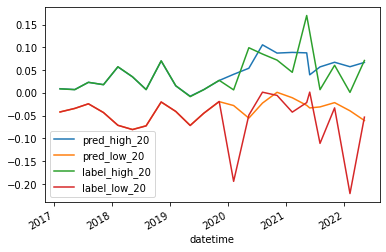

In [173]:
# ラベルもつけて返してみる
code = example_codes[0]
df_label = stock_labels[stock_labels["Local Code"]==code].copy()
feat = ["base_date", "label_high_20", "label_low_20"]
df_label = df_label[feat]
df_label.columns = ["datetime", "label_high_20", "label_low_20"]

df_label["datetime"] = pd.to_datetime(df_label["datetime"])
df_label = df_label.set_index(["datetime"])

result_to_draw = result.reset_index()
result_to_draw = result_to_draw[result_to_draw["code"]==code].set_index("datetime")
result_to_draw = result_to_draw[["pred_high_20","pred_low_20"]]

result_to_draw = pd.concat([result_to_draw, df_label[df_label.index.isin(result_to_draw.index)]], axis=1)
result_to_draw.plot.line()
result_to_draw


これでチュートリアルは終了です。お疲れ様でした！